# Opti Pipe

In [1]:
from opti_pipe import Model, Floor, Distributor,Node,NodeType, RoomConnection, Graph
from opti_pipe.utils import load_config
from opti_pipe.router import NaiveRouter

Domain language

* inputs are always hot (outputs cooler)

In [2]:
config = load_config()

In [ ]:
floor = Floor(config=config,corners=[(0,0),(0,5),(5,5),(5,0)])

distributor = Distributor(config=config,nodes=(
    Node(config,2.0,0,node_type=NodeType.INPUT),
    Node(config,2.2,0,node_type=NodeType.OUTPUT),
    Node(config,2.4,0,node_type=NodeType.INPUT),
    Node(config,2.6,0,node_type=NodeType.OUTPUT),
    Node(config,2.8,0,node_type=NodeType.INPUT),
    Node(config,3.0,0,node_type=NodeType.OUTPUT)),
    heat_per_node=1)

room_connections = (RoomConnection(config,output=Node(config,0,3.75,node_type=NodeType.OUTPUT),input=Node(config,0,3.5,node_type=NodeType.INPUT),heat_loss=0.8),
                    RoomConnection(config,output=Node(config,5,3,node_type=NodeType.OUTPUT),input=Node(config,5,3.25,node_type=NodeType.INPUT),heat_loss=0.5),
                    RoomConnection(config,output=Node(config,2.6,5,node_type=NodeType.OUTPUT),input=Node(config,2.4,5,node_type=NodeType.INPUT),heat_loss=0.3))


In [4]:
model = Model(
    config = config,
    target_heat_input=100,
    floor=floor,
    distributor=distributor,
    room_connections=room_connections)

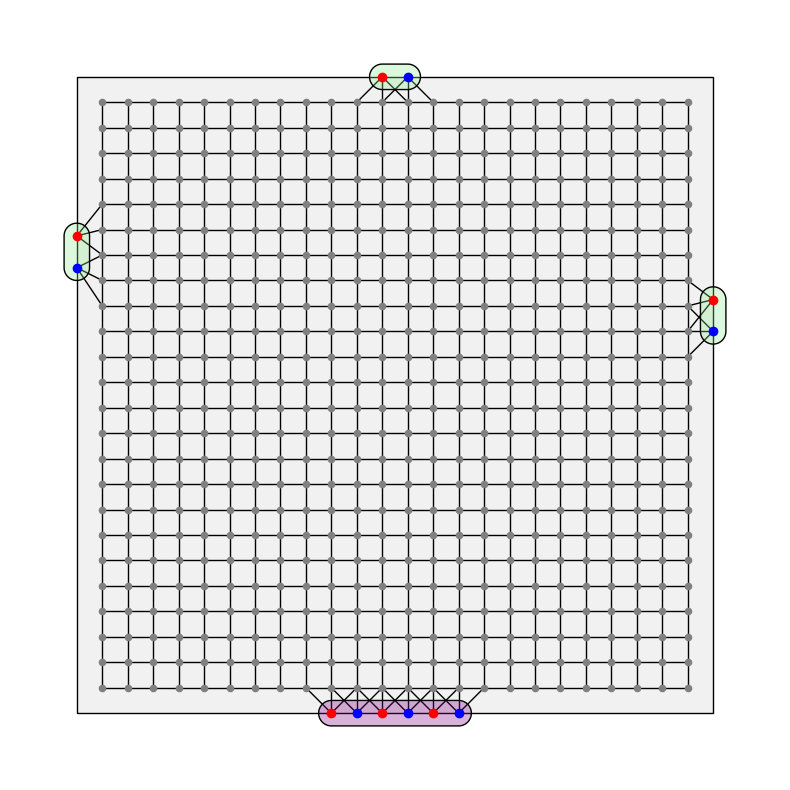

In [5]:

grid_size = 0.2
model.add_graph(grid_size)
model.render(show_graph=True)

Path not found between 2.2_0_NodeType.OUTPUT and 0_3.5_NodeType.OUTPUT


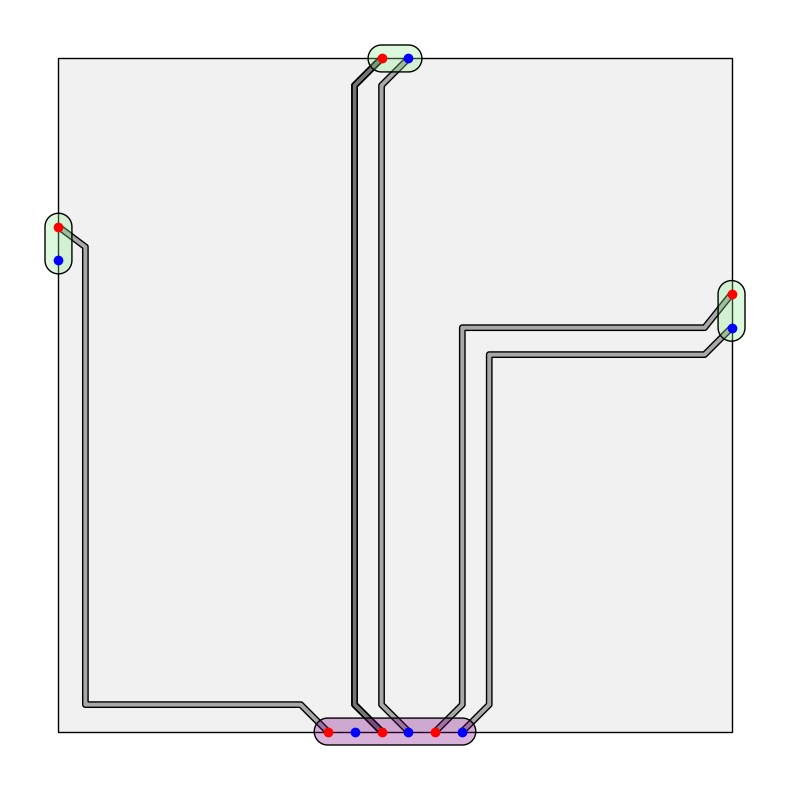

In [6]:
model.pipes = tuple()
router = NaiveRouter(config,model,grid_size)
model = router.route()
model.render(show_graph=False,render_heat_distribution=False)

# from opti_pipe.router import Utils
# line_string = Utils.get_centerline(model,grid_size)
# from shapely.plotting import plot_polygon
# plot_polygon(line_string)

In [7]:
from ortools.sat.python import cp_model

def solve_disjoint_paths(grid_size, endpoints):
    model = cp_model.CpModel()
    nodes = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    
    # Function to return valid neighbor coordinates (up, down, left, right)
    def get_neighbors(node):
        i, j = node
        nbrs = []
        for di, dj in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < grid_size and 0 <= nj < grid_size:
                nbrs.append((ni, nj))
        return nbrs
    
    num_commodities = len(endpoints)  # number of pairs/paths

    # Create binary variables for each commodity k and each (undirected) edge.
    # We create a variable x[(k, u, v)] for an edge between nodes u and v.
    # (We only define one variable per undirected edge.)
    x = {}
    for k in range(num_commodities):
        for node in nodes:
            for nbr in get_neighbors(node):
                if node < nbr:  # order the pair to avoid double counting
                    x[(k, node, nbr)] = model.NewBoolVar(f"x_{k}_{node}_{nbr}")
                    # (x[(k, nbr, node)] is the same edge)
                    x[(k, nbr, node)] = x[(k, node, nbr)]
    
    # Create a binary variable y[(node, k)] indicating whether node is in commodity k's path.
    y = {}
    for node in nodes:
        for k in range(num_commodities):
            y[(node, k)] = model.NewBoolVar(f"y_{node}_{k}")
    
    # Each node must belong to exactly one commodity’s path.
    for node in nodes:
        model.Add(sum(y[(node, k)] for k in range(num_commodities)) == 1)
    
    # Add degree constraints for each node and commodity.
    # For each commodity k, if a node is used (y[node,k]==1):
    #   - If it is an endpoint, then it must have exactly one incident edge.
    #   - Otherwise, it must have exactly two incident edges.
    for k in range(num_commodities):
        source, sink = endpoints[k]
        for node in nodes:
            # Gather all incident edges (using our x variables)
            incident = []
            for nbr in get_neighbors(node):
                # (x is defined for both (node, nbr) and (nbr, node) identically)
                incident.append(x[(k, node, nbr)])
            if node == source or node == sink:
                model.Add(sum(incident) == y[(node, k)])
            else:
                model.Add(sum(incident) == 2 * y[(node, k)])
    
    # --- Connectivity / Subtour elimination ---
    # We introduce an integer variable "order" for each node in each commodity's path.
    # These are used in Miller-Tucker-Zemlin style constraints to force a connected ordering.
    order = {}
    M = grid_size * grid_size  # A big constant
    for k in range(num_commodities):
        for node in nodes:
            order[(node, k)] = model.NewIntVar(0, M - 1, f"order_{node}_{k}")
    
    # For each commodity, fix the order of the source to 0.
    for k in range(num_commodities):
        source, sink = endpoints[k]
        model.Add(order[(source, k)] == 0)
    
    # If an edge is used in commodity k between u and v then enforce an order difference.
    # (This is a common trick to eliminate subtours in routing problems.)
    for k in range(num_commodities):
        for node in nodes:
            for nbr in get_neighbors(node):
                if node < nbr:
                    # If x[(k, node, nbr)] == 1 then order[nbr] must be at least order[node] + 1
                    model.Add(order[(node, k)] + 1 <= order[(nbr, k)] + M * (1 - x[(k, node, nbr)]))
                    model.Add(order[(nbr, k)] + 1 <= order[(node, k)] + M * (1 - x[(k, node, nbr)]))
    
    # Solve the model.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    
    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        paths = {k: [] for k in range(num_commodities)}
        # Reconstruct paths: for each commodity, start at the source and follow used edges.
        for k in range(num_commodities):
            source, sink = endpoints[k]
            path = [source]
            current = source
            visited = {source}
            # We use a simple loop; in a full solution you’d need to check that every node is eventually reached.
            while current != sink:
                found_next = False
                for nbr in get_neighbors(current):
                    if solver.Value(x[(k, current, nbr)]) == 1 and nbr not in visited:
                        path.append(nbr)
                        visited.add(nbr)
                        current = nbr
                        found_next = True
                        break
                if not found_next:
                    print(f"Path reconstruction failed for commodity {k}")
                    break
            paths[k] = path
        return paths
    else:
        print("No solution found")
        return None

if __name__ == "__main__":
    # For demonstration, use a small grid. Scaling to 100x100 will be much more computationally intense.
    grid_size = 5  
    # Define endpoints for four pairs.
    endpoints = {
        0: ((0, 0), (grid_size - 1, grid_size - 1)),
        1: ((0, grid_size - 1), (grid_size - 1, 0)),
        2: ((0, grid_size // 2), (grid_size - 1, grid_size // 2)),
        3: ((grid_size // 2, 0), (grid_size // 2, grid_size - 1))
    }
    
    paths = solve_disjoint_paths(grid_size, endpoints)
    if paths:
        for k, p in paths.items():
            print(f"Path for commodity {k}: {p}")


No solution found
